# Linear regression diagnostics

In real-life, relation between response and target variables are seldom linear. Here, we make use of outputs of ``statsmodels`` to visualise and identify potential problems that can occur from fitting ``linear regression`` model to non-linear relation. Primarily, the aim is to reproduce visualisations discussed in Potential Problems section (Chapter 3.3.3) of *An Introduction to Statistical Learning* (ISLR) book by James et al., Springer.

In [1]:
import statsmodels
import statsmodels.formula.api as smf
import pandas as pd

#### Simple multiple linear regression

Firstly, let us load the Advertising data from Chapter 2 of ISLR book and fit a linear model to it.

In [2]:
# Load data
data_url = "https://raw.githubusercontent.com/nguyen-toan/ISLR/07fd968ea484b5f6febc7b392a28eb64329a4945/dataset/Advertising.csv"
df = pd.read_csv(data_url).drop("Unnamed: 0", axis=1)
df.head()

,TV,Radio,Newspaper,Sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9


In [3]:
# Fitting linear model
res = smf.ols(formula="Sales ~ TV + Radio + Newspaper", data=df).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     570.3
Date:                Fri, 12 Sep 2025   Prob (F-statistic):           1.58e-96
Time:                        17:40:01   Log-Likelihood:                -386.18
No. Observations:                 200   AIC:                             780.4
Df Residuals:                     196   BIC:                             793.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.9389      0.312      9.422      0.000       2.324       3.554
TV             0.0458      0.001     32.809      0.000       0.043       0.049
Radio          0.1885      0.009     21.893      0.000       0.172       0.206
Newspaper     -0.0010      0.006     -0.177      0.860      -0.013       0.011
==============================================================================
Omnibus:                       60.414   Durbin-Watson:                   2.084
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              151.241
Skew:                          -1.327   Prob(JB):                     1.44e-33
Kurtosis:                       6.332   Cond. No.                         454.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Diagnostic Figures/Table

In the following first we present a base code that we will later use to generate following diagnostic plots:

    a. residual
    b. qq
    c. scale location
    d. leverage

and a table

    a. vif

In [4]:
# base code
import numpy as np
import seaborn as sns
from statsmodels.tools.tools import maybe_unwrap_results
from statsmodels.graphics.gofplots import ProbPlot
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
from typing import Type

style_talk = "seaborn-talk"  # refer to plt.style.available


class LinearRegDiagnostic:
    """
    Diagnostic plots to identify potential problems in a linear regression fit.
    Mainly,
        a. non-linearity of data
        b. Correlation of error terms
        c. non-constant variance
        d. outliers
        e. high-leverage points
        f. collinearity

    Authors:
        Prajwal Kafle (p33ajkafle@gmail.com, where 3 = r)
        Does not come with any sort of warranty.
        Please test the code one your end before using.

        Matt Spinelli (m3spinelli@gmail.com, where 3 = r)
        (1) Fixed incorrect annotation of the top most extreme residuals in
            the Residuals vs Fitted and, especially, the Normal Q-Q plots.
        (2) Changed Residuals vs Leverage plot to match closer the y-axis
            range shown in the equivalent plot in the R package ggfortify.
        (3) Added horizontal line at y=0 in Residuals vs Leverage plot to
            match the plots in R package ggfortify and base R.
        (4) Added option for placing a vertical guideline on the Residuals
            vs Leverage plot using the rule of thumb of h = 2p/n to denote
            high leverage (high_leverage_threshold=True).
        (5) Added two more ways to compute the Cook's Distance (D) threshold:
            * 'baseR': D > 1 and D > 0.5 (default)
            * 'convention': D > 4/n
            * 'dof': D > 4 / (n - k - 1)
        (6) Fixed class name to conform to Pascal casing convention
        (7) Fixed Residuals vs Leverage legend to work with loc='best'
    """

    def __init__(
        self,
        results: Type[statsmodels.regression.linear_model.RegressionResultsWrapper],
    ) -> None:
        """
        For a linear regression model, generates following diagnostic plots:

        a. residual
        b. qq
        c. scale location and
        d. leverage

        and a table

        e. vif

        Args:
            results (Type[statsmodels.regression.linear_model.RegressionResultsWrapper]):
                must be instance of statsmodels.regression.linear_model object

        Raises:
            TypeError: if instance does not belong to above object

        Example:
        >>> import numpy as np
        >>> import pandas as pd
        >>> import statsmodels.formula.api as smf
        >>> x = np.linspace(-np.pi, np.pi, 100)
        >>> y = 3*x + 8 + np.random.normal(0,1, 100)
        >>> df = pd.DataFrame({'x':x, 'y':y})
        >>> res = smf.ols(formula= "y ~ x", data=df).fit()
        >>> cls = Linear_Reg_Diagnostic(res)
        >>> cls(plot_context="seaborn-v0_8-paper")

        In case you do not need all plots you can also independently make an individual plot/table
        in following ways

        >>> cls = Linear_Reg_Diagnostic(res)
        >>> cls.residual_plot()
        >>> cls.qq_plot()
        >>> cls.scale_location_plot()
        >>> cls.leverage_plot()
        >>> cls.vif_table()
        """

        if (
            isinstance(
                results, statsmodels.regression.linear_model.RegressionResultsWrapper
            )
            is False
        ):
            raise TypeError(
                "result must be instance of statsmodels.regression.linear_model.RegressionResultsWrapper object"
            )

        self.results = maybe_unwrap_results(results)

        self.y_true = self.results.model.endog
        self.y_predict = self.results.fittedvalues
        self.xvar = self.results.model.exog
        self.xvar_names = self.results.model.exog_names

        self.residual = np.array(self.results.resid)
        influence = self.results.get_influence()
        self.residual_norm = influence.resid_studentized_internal
        self.leverage = influence.hat_matrix_diag
        self.cooks_distance = influence.cooks_distance[0]
        self.nparams = len(self.results.params)
        self.nresids = len(self.residual_norm)

    def __call__(self, plot_context="seaborn-v0_8-paper", **kwargs):
        # print(plt.style.available)
        # GH#9157
        if plot_context not in plt.style.available:
            plot_context = "default"
        with plt.style.context(plot_context):
            fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
            self.residual_plot(ax=ax[0, 0])
            self.qq_plot(ax=ax[0, 1])
            self.scale_location_plot(ax=ax[1, 0])
            self.leverage_plot(
                ax=ax[1, 1],
                high_leverage_threshold=kwargs.get("high_leverage_threshold"),
                cooks_threshold=kwargs.get("cooks_threshold"),
            )
            plt.show()

        return (
            self.vif_table(),
            fig,
            ax,
        )

    def residual_plot(self, ax=None):
        """
        Residual vs Fitted Plot

        Graphical tool to identify non-linearity.
        (Roughly) Horizontal red line is an indicator that the residual has a linear pattern
        """
        if ax is None:
            fig, ax = plt.subplots()

        sns.residplot(
            x=self.y_predict,
            y=self.residual,
            lowess=True,
            scatter_kws={"alpha": 0.5},
            line_kws={"color": "red", "lw": 1, "alpha": 0.8},
            ax=ax,
        )

        # annotations
        residual_abs = np.abs(self.residual)
        abs_resid = np.flip(np.argsort(residual_abs), 0)
        abs_resid_top_3 = abs_resid[:3]
        for i in abs_resid_top_3:
            ax.annotate(i, xy=(self.y_predict[i], self.residual[i]), color="C3")

        ax.set_title("Residuals vs Fitted", fontweight="bold")
        ax.set_xlabel("Fitted values")
        ax.set_ylabel("Residuals")
        return ax

    def qq_plot(self, ax=None):
        """
        Standarized Residual vs Theoretical Quantile plot

        Used to visually check if residuals are normally distributed.
        Points spread along the diagonal line will suggest so.
        """
        if ax is None:
            fig, ax = plt.subplots()

        QQ = ProbPlot(self.residual_norm)
        fig = QQ.qqplot(line="45", alpha=0.5, lw=1, ax=ax)

        # annotations
        abs_norm_resid = np.flip(np.argsort(np.abs(self.residual_norm)), 0)
        abs_norm_resid_top_3 = abs_norm_resid[:3]
        for i, x, y in self.__qq_top_resid(
            QQ.theoretical_quantiles, abs_norm_resid_top_3
        ):
            ax.annotate(i, xy=(x, y), ha="right", color="C3")

        ax.set_title("Normal Q-Q", fontweight="bold")
        ax.set_xlabel("Theoretical Quantiles")
        ax.set_ylabel("Standardized Residuals")
        return ax

    def scale_location_plot(self, ax=None):
        """
        Sqrt(Standarized Residual) vs Fitted values plot

        Used to check homoscedasticity of the residuals.
        Horizontal line will suggest so.
        """
        if ax is None:
            fig, ax = plt.subplots()

        residual_norm_abs_sqrt = np.sqrt(np.abs(self.residual_norm))

        ax.scatter(self.y_predict, residual_norm_abs_sqrt, alpha=0.5)
        sns.regplot(
            x=self.y_predict,
            y=residual_norm_abs_sqrt,
            scatter=False,
            ci=False,
            lowess=True,
            line_kws={"color": "red", "lw": 1, "alpha": 0.8},
            ax=ax,
        )

        # annotations
        abs_sq_norm_resid = np.flip(np.argsort(residual_norm_abs_sqrt), 0)
        abs_sq_norm_resid_top_3 = abs_sq_norm_resid[:3]
        for i in abs_sq_norm_resid_top_3:
            ax.annotate(
                i, xy=(self.y_predict[i], residual_norm_abs_sqrt[i]), color="C3"
            )

        ax.set_title("Scale-Location", fontweight="bold")
        ax.set_xlabel("Fitted values")
        ax.set_ylabel(r"$\sqrt{|\mathrm{Standardized\ Residuals}|}$")
        return ax

    def leverage_plot(
        self, ax=None, high_leverage_threshold=False, cooks_threshold="baseR"
    ):
        """
        Residual vs Leverage plot

        Points falling outside Cook's distance curves are considered observation that can sway the fit
        aka are influential.
        Good to have none outside the curves.
        """
        if ax is None:
            fig, ax = plt.subplots()

        ax.scatter(self.leverage, self.residual_norm, alpha=0.5)

        sns.regplot(
            x=self.leverage,
            y=self.residual_norm,
            scatter=False,
            ci=False,
            lowess=True,
            line_kws={"color": "red", "lw": 1, "alpha": 0.8},
            ax=ax,
        )

        # annotations
        leverage_top_3 = np.flip(np.argsort(self.cooks_distance), 0)[:3]
        for i in leverage_top_3:
            ax.annotate(i, xy=(self.leverage[i], self.residual_norm[i]), color="C3")

        factors = []
        if cooks_threshold == "baseR" or cooks_threshold is None:
            factors = [1, 0.5]
        elif cooks_threshold == "convention":
            factors = [4 / self.nresids]
        elif cooks_threshold == "dof":
            factors = [4 / (self.nresids - self.nparams)]
        else:
            raise ValueError(
                "threshold_method must be one of the following: 'convention', 'dof', or 'baseR' (default)"
            )
        for i, factor in enumerate(factors):
            label = "Cook's distance" if i == 0 else None
            xtemp, ytemp = self.__cooks_dist_line(factor)
            ax.plot(xtemp, ytemp, label=label, lw=1.25, ls="--", color="red")
            ax.plot(xtemp, np.negative(ytemp), lw=1.25, ls="--", color="red")

        if high_leverage_threshold:
            high_leverage = 2 * self.nparams / self.nresids
            if max(self.leverage) > high_leverage:
                ax.axvline(
                    high_leverage, label="High leverage", ls="-.", color="purple", lw=1
                )

        ax.axhline(0, ls="dotted", color="black", lw=1.25)
        ax.set_xlim(0, max(self.leverage) + 0.01)
        ax.set_ylim(min(self.residual_norm) - 0.1, max(self.residual_norm) + 0.1)
        ax.set_title("Residuals vs Leverage", fontweight="bold")
        ax.set_xlabel("Leverage")
        ax.set_ylabel("Standardized Residuals")
        plt.legend(loc="best")
        return ax

    def vif_table(self):
        """
        VIF table

        VIF, the variance inflation factor, is a measure of multicollinearity.
        VIF > 5 for a variable indicates that it is highly collinear with the
        other input variables.
        """
        vif_df = pd.DataFrame()
        vif_df["Features"] = self.xvar_names
        vif_df["VIF Factor"] = [
            variance_inflation_factor(self.xvar, i) for i in range(self.xvar.shape[1])
        ]

        return vif_df.sort_values("VIF Factor").round(2)

    def __cooks_dist_line(self, factor):
        """
        Helper function for plotting Cook's distance curves
        """
        p = self.nparams
        formula = lambda x: np.sqrt((factor * p * (1 - x)) / x)
        x = np.linspace(0.001, max(self.leverage), 50)
        y = formula(x)
        return x, y

    def __qq_top_resid(self, quantiles, top_residual_indices):
        """
        Helper generator function yielding the index and coordinates
        """
        offset = 0
        quant_index = 0
        previous_is_negative = None
        for resid_index in top_residual_indices:
            y = self.residual_norm[resid_index]
            is_negative = y < 0
            if previous_is_negative == None or previous_is_negative == is_negative:
                offset += 1
            else:
                quant_index -= offset
            x = (
                quantiles[quant_index]
                if is_negative
                else np.flip(quantiles, 0)[quant_index]
            )
            quant_index += 1
            previous_is_negative = is_negative
            yield resid_index, x, y

Making use of the 

    * fitted model on the Advertising data above and 
    * the base code provided
now we generate diagnostic plots one by one.

In [5]:
cls = LinearRegDiagnostic(res)

**A. Residual vs Fitted values**

Graphical tool to identify non-linearity.

In the graph red (roughly) horizontal line is an indicator that the residual has a linear pattern.

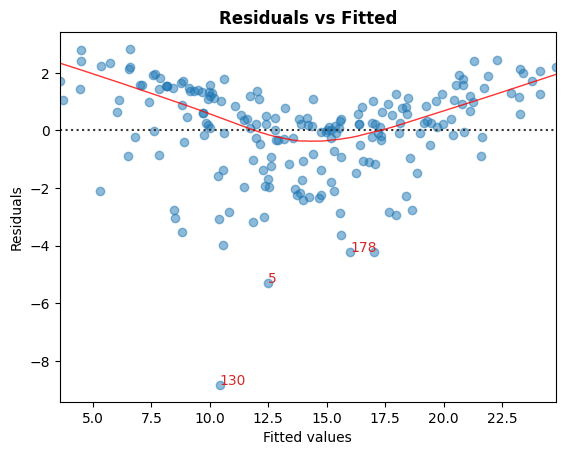

In [6]:
cls.residual_plot();

**B. Standarized Residual vs Theoretical Quantile**

This plot is used to visually check if residuals are normally distributed.

Points spread along the diagonal line will suggest so.

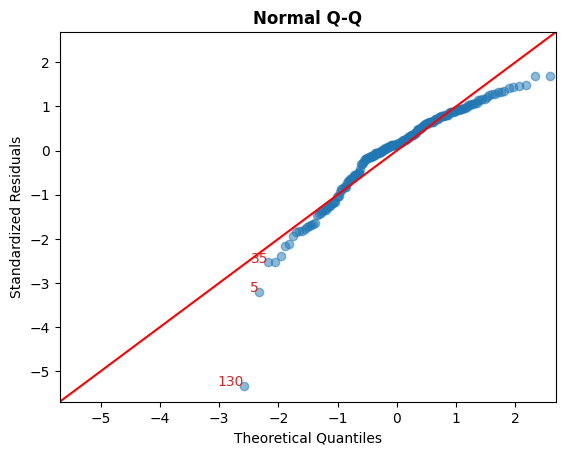

In [7]:
cls.qq_plot();

**C. Sqrt(Standarized Residual) vs Fitted values**

This plot is used to check homoscedasticity of the residuals.

A near horizontal red line in the graph would suggest so.

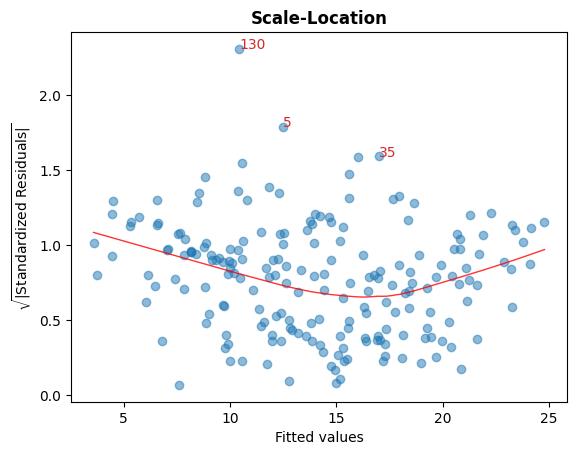

In [8]:
cls.scale_location_plot();

**D. Residual vs Leverage**

Points falling outside the Cook's distance curves are considered observation that can sway the fit aka are influential.

Good to have no points outside these curves.

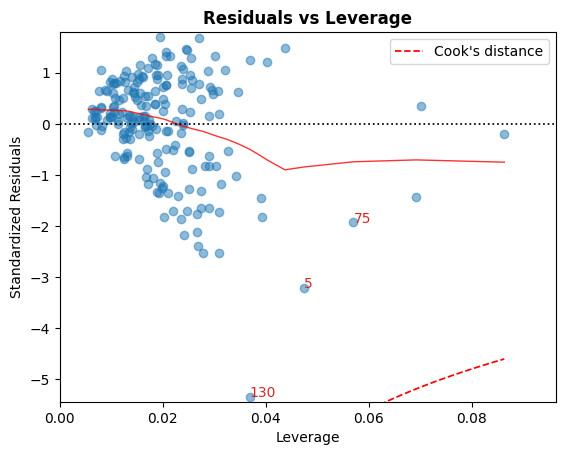

In [9]:
cls.leverage_plot();

Cook's distance curves can be drawn using other rules of thumbs:

| Rule of Thumb    | Threshold(s) |
| :----------- | ----------- |
| `'baseR'` (**default**) | $$D_i > 1 \mid D_i > 0.5$$ |
| `'convention'` | $$D_i > { 4 \over n}$$ |
| `'dof'` | $$D_i > {4 \over n - k - 1}$$ |

A high leverage guideline can also be displayed using the convention: $h_{ii} > {2p \over n}$.

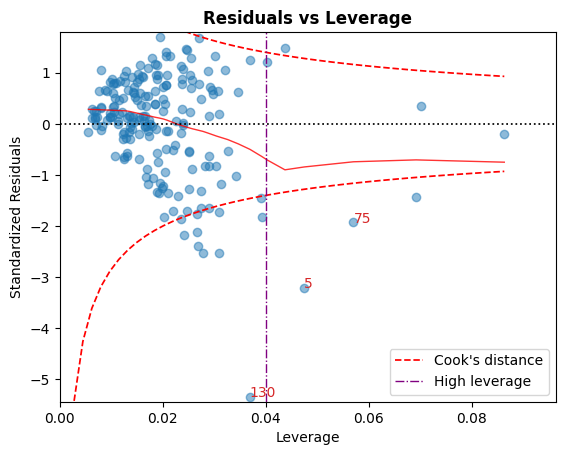

In [10]:
cls.leverage_plot(high_leverage_threshold=True, cooks_threshold="dof");

**E. VIF**

The variance inflation factor (VIF), is a measure of multicollinearity.

VIF > 5 for a variable indicates that it is highly collinear with the 
other input variables.

In [11]:
cls.vif_table()

,Features,VIF Factor
1,TV,1.00
2,Radio,1.14
3,Newspaper,1.15
0,Intercept,6.85


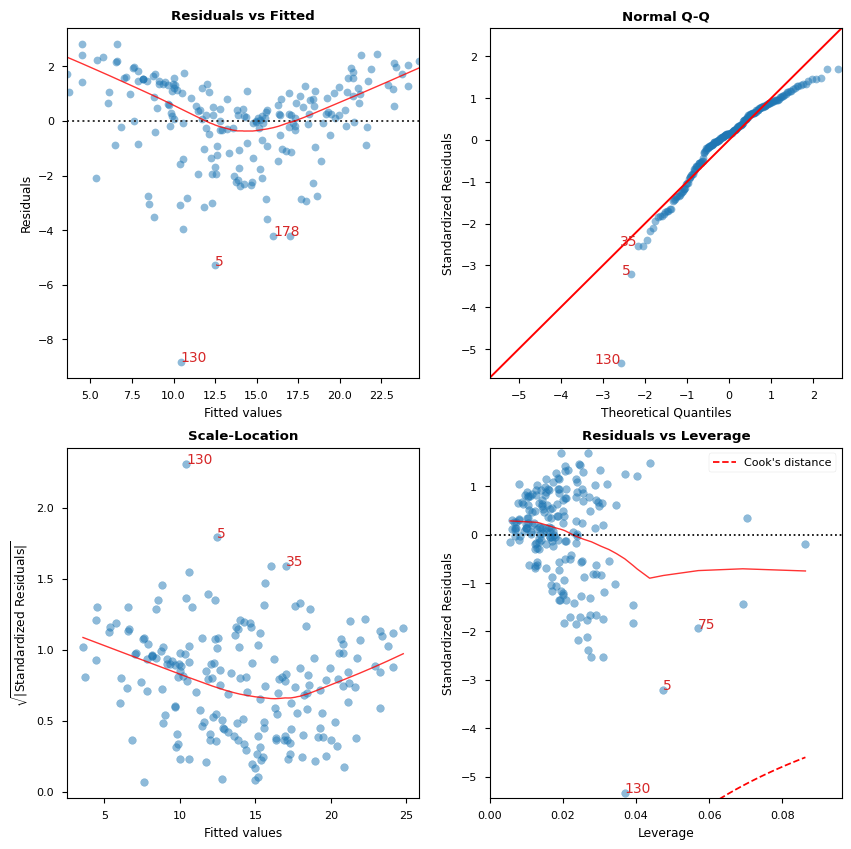

    Features  VIF Factor
1         TV        1.00
2      Radio        1.14
3  Newspaper        1.15
0  Intercept        6.85


In [12]:
# Alternatively, all diagnostics can be generated in one go as follows.
# Fig and ax can be used to modify axes or plot properties after the fact.
cls = LinearRegDiagnostic(res)
vif, fig, ax = cls()
print(vif)

# fig.savefig('../../docs/source/_static/images/linear_regression_diagnostics_plots.png')

For detail discussions on the interpretation and caveats of the above plots please refer to the ISLR book.